# xDbit - characterization of channel flow

## Measurement of channel lengths

The channel lengths were measured from `xDbit_50um_horizontal.dwg` using Autodesk DWG TrueView 2023 and eDrawings. In eDrawings I determined the perimeter of the inlets/outlets to be 6.9 mm. In TrueView I used the Measure List tool to select all channels (including the inlet and outlets) and print the results by pressing ENTER. The results were copied into a text file and perimeters need to be extracted here.

### Extraction of perimeters from text file

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from scipy import stats
import statsmodels.api as sm

In [2]:
plt.rcParams['figure.dpi'] = 100
plt.style.use('default')

In [3]:
text_file = "../source_data/lengths_horizontal_chip.txt"

file = open(text_file, 'r')
lines = file.readlines()

In [4]:
perimeters = [l for l in lines if "perimeter" in l]
perimeters = [float(p.split(" ")[-1].strip()) for p in perimeters]

data = pd.DataFrame({
    "perimeter": perimeters
})

### Calculate channel length

length = (perimeter - 2 * 6.9mm) / 2

In [5]:
# calc
data["length"] = [(elem - 2*6.9) / 2 for elem in data["perimeter"]]

# reshape data
data["id"] = range(1, len(data)+1)
unique_lengths = np.unique(data.sort_values('length').length)
ldict = {elem: i+1 for i, elem in enumerate(unique_lengths)}
data["length_id"] = [ldict[elem] for elem in data["length"]]

## Measurement results

In [9]:
# read data
resfile = "../source_data/results_channel_flow.xlsx"
results = pd.read_excel(resfile)

In [10]:
# reshape data
results["length"] = np.unique(data.sort_values("length")["length"].values)
results = results.melt(id_vars="length", value_vars=list("ABCD"))
results = results.rename(columns={"value": "volume"})

### Calculate flow rate from volume

The experiment was run for 60s at 300 mbar.

In [11]:
results["flow rate"] = [elem / 1 for elem in results["volume"]] # in µm/min


## Plot and do linear regression and pearsson

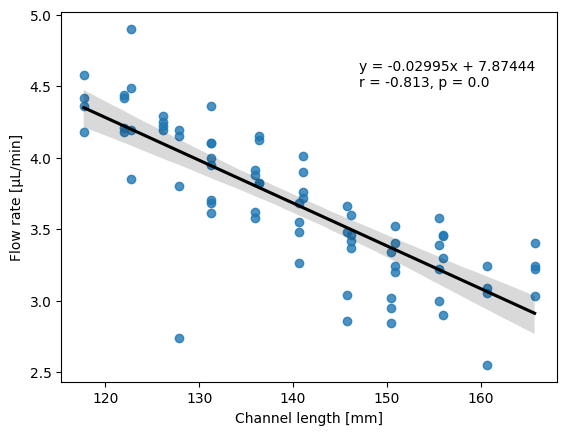

In [12]:
fig, ax = plt.subplots(1,1)

sns.regplot(data=results, 
            x="length", 
            y="flow rate", 
            line_kws={"color": "k"},
            ax=ax)
ax.set_xlabel("Channel length [mm]")
ax.set_ylabel("Flow rate [µL/min]")

# do linear regression
lm = LinearRegression()
x = results["length"].values
y = results["flow rate"].values
lm.fit(x.reshape(-1,1), y.reshape(-1,1))

# get parameters
slope = lm.coef_[0][0]
intercept = lm.intercept_[0]

# calc pearson r
r, p = stats.pearsonr(x=x, y=y)

# add annotation of equation and R²
ax.annotate(
    "y = {}x + {}\nr = {}, p = {}".format(
    round(slope, 5), 
    round(intercept, 5),
    round(r, 3), 
    round(p, 3)
    ), 
            xy=(0.6,0.8), 
            xycoords='axes fraction')

plt.savefig("figures/lineplot_flowrate.pdf")
plt.savefig("figures/lineplot_flowrate.png")
plt.show()

## Interpolation of data to find point of no flow

Using statsmodel:
- https://www.statsmodels.org/dev/regression.html
- https://www.statsmodels.org/dev/examples/notebooks/generated/predict.html
- https://stackoverflow.com/questions/17559408/confidence-and-prediction-intervals-with-statsmodels

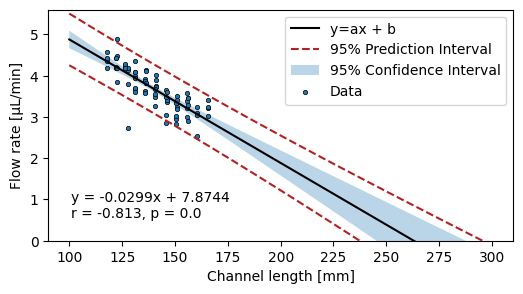

In [13]:
fig, ax = plt.subplots(1,1, figsize=(6, 3))

# do linear regression
x = results["length"].values
X = sm.add_constant(x)

y = results["flow rate"].values
olsmod = sm.OLS(endog=y, exog=X)
olsres = olsmod.fit()

# predict values
ypred = olsres.predict(X)

# convert to pandas dataframe
summary = olsres.summary()
results_as_html = summary.tables[1].as_html()
params = pd.read_html(results_as_html, header=0, index_col=0)[0]

# get parameters
slope = params.loc["x1", "coef"]
intercept = params.loc["const", "coef"]

# calc pearson r
r, p = stats.pearsonr(x=x, y=y)

# add annotation of equation and R²
ax.annotate(
    "y = {}x + {}\nr = {}, p = {}".format(
    round(slope, 5), 
    round(intercept, 5),
    round(r, 3), 
    round(p, 3)
    ), 
            xy=(0.05,0.1), 
            xycoords='axes fraction')

# out of sample prediction
xnew = np.linspace(100, 300, 100)
Xnew = sm.add_constant(xnew)
#ynew = olsres.predict(Xnew) # predict out of sample

# get out of sample prediction results with statistics
predsum = olsres.get_prediction(Xnew).summary_frame(alpha=0.05)
ynew = predsum["mean"].values
ci_lower = predsum["mean_ci_lower"]
ci_upper = predsum["mean_ci_upper"]
predci_lower = predsum["obs_ci_lower"]
predci_upper = predsum["obs_ci_upper"]

ax.plot(xnew, ynew, c='k', label="y=ax + b")
ax.plot(xnew, predci_lower, linestyle='dashed', c='firebrick', 
        label="95% Prediction Interval"
       )
ax.plot(xnew, predci_upper, linestyle='dashed', c='firebrick')
ax.fill_between(xnew, ci_lower, ci_upper, alpha=0.3, 
                label="95% Confidence Interval"
               )
ax.scatter(x, y, c='C0', edgecolors='k', linewidth=0.5, s=10, label="Data")

# set axis limits
#ax.set_xlim(120, 170)
ax.set_ylim(0, 5.6)

# set axis labels
ax.set_xlabel("Channel length [mm]")
ax.set_ylabel("Flow rate [µL/min]")

ax.legend()

plt.savefig("figures/lineplot_flowrate_prediction.pdf", bbox_inches="tight")
plt.savefig("figures/lineplot_flowrate_prediction.png", bbox_inches="tight")

plt.show()